In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import random

In [2]:
env = gym.make("CartPole-v0")

# Random actions only

In [11]:
env.reset()
done = False
score = 0
frames = []

while not done:
    action = env.action_space.sample()
    new_state, reward, done, info = env.step(action)
    
    score += reward
    frames.append(Image.fromarray(env.render(mode="rgb_array")))
    
print(f"Total reward is: {score}")
env.close()

frames[0].save("CartPole Before Training Random Movement.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

Total reward is: 19.0


## Replay Memory

In [3]:
class ReplayMemory:
    def __init__(self, capacity, input_shape):
        self.capacity = capacity
        self.memory_counter = 0

        self.state_memory = np.zeros((self.capacity, *input_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.capacity, dtype=np.int64)
        self.reward_memory = np.zeros(self.capacity, dtype=np.float32)
        self.next_state_memory = np.zeros((self.capacity, *input_shape), dtype=np.float32)
        self.terminal_memory = np.zeros(self.capacity, dtype=np.uint8)

    def store(self, state, action, reward, next_state, done):
        index = self.memory_counter % self.capacity
        
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = done

        self.memory_counter += 1

    def sample(self, batch_size):
        max_memory = min(self.memory_counter, self.capacity)
        batch = np.random.choice(max_memory, batch_size, replace=False)

        states = self.state_memory[batch]
        next_states = self.next_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return min(self.memory_counter, self.capacity)

## Deep Q Network with 1 hidden layers

In [4]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions, lr):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(*input_shape, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.to(self.device)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Agents

## Q

In [5]:
class Agent_Q:
    def __init__(self, env, lr, epsilon_start, epsilon_end, epsilon_decay, discount):
        self.env = env
        self.observation_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.action_space = [action for action in range(self.num_actions)]
        
        self.lr = lr
        self.discount = discount
        
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        self.space_1 = np.linspace(self.env.observation_space.low[0], self.env.observation_space.high[0], 20)
        self.space_2 = np.linspace(self.env.observation_space.low[1], self.env.observation_space.high[1], 20)
        self.space_3 = np.linspace(self.env.observation_space.low[2], self.env.observation_space.high[2], 20)
        self.space_4 = np.linspace(self.env.observation_space.low[3], self.env.observation_space.high[3], 20)

        self.states = []
        for sp_1 in range(len(self.space_1)+1):
            for sp_2 in range(len(self.space_2)+1):
                for sp_3 in range(len(self.space_3)+1):
                    for sp_4 in range(len(self.space_4)+1):
                        self.states.append((sp_1, sp_2, sp_3, sp_4))
                
        self.Q_table = {}
        for state in self.states:
            for action in self.action_space:
                self.Q_table[state, action] = 0
        
    def get_state(self, observation):
        sp_1, sp_2, sp_3, sp_4 = observation
        space_1_bin = int(np.digitize(sp_1, self.space_1))
        space_2_bin = int(np.digitize(sp_2, self.space_2))
        space_3_bin = int(np.digitize(sp_3, self.space_3))
        space_4_bin = int(np.digitize(sp_4, self.space_4))
        
        return space_1_bin, space_2_bin, space_3_bin, space_4_bin
    
    def get_max_action(self, state):
        values = np.array([self.Q_table[state, action] for action in self.action_space])
        max_action = np.argmax(values)

        return max_action
        
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)
    
    def choose_action(self, observation):
        if np.random.random() >= self.epsilon:
            action = self.get_max_action(observation)
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self, state, action, reward, next_state):
        next_action = self.get_max_action(next_state)
        self.Q_table[state, action] = self.Q_table[state, action] + self.lr * (reward + self.discount * self.Q_table[next_state, next_action] - self.Q_table[state, action])
        
        self.update_epsilon()

## DQN

In [6]:
class Agent_DQN:
    def __init__(self, env, lr, epsilon_start, epsilon_end, epsilon_decay, discount):
        self.env = env
        self.state_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.action_space = [action for action in range(self.num_actions)]
        
        self.lr = lr
        self.discount = discount
        
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        self.q_online = DQN(self.state_shape, self.num_actions, self.lr)
        
    def choose_action(self, observation):
        # We use epsilon-greedy policy
        if np.random.random() >= self.epsilon:
            # In case that device is CUDA we have to sent it to GPU instead of CPU, also we have to transform it to torch tensor
            state = torch.tensor([observation], dtype=torch.float).to(self.q_online.device)
            with torch.no_grad():
                actions = self.q_online(state)
            # Take action with the highest value
            action = torch.argmax(actions).item()
        
        else:
            # Take random action in action space, eg. action space is [0, 1, 2] it takes 2nd action
            action = np.random.choice(self.action_space)
            
        return action
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)
      
    def learn(self, state, action, reward, next_state):
        # Zero the gradients
        self.q_online.optimizer.zero_grad()
        
        # Turning numpy arrays into torch tensors
        state_t = torch.tensor(state, dtype=torch.float).to(self.q_online.device)
        action_t = torch.tensor(action, dtype=torch.int).to(self.q_online.device)
        reward_t = torch.tensor(reward, dtype=torch.float).to(self.q_online.device)
        next_state_t = torch.tensor(next_state, dtype=torch.float).to(self.q_online.device)
        
        # Estimating Q value
        q_pred = self.q_online(state_t)[action_t]
        q_next = self.q_online(next_state_t).max()
        q_target = reward + self.discount * q_next
        
        # Calculating loss
        loss = self.q_online.loss(q_target, q_pred).to(self.q_online.device)
        
        # Backprop
        loss.backward()
        self.q_online.optimizer.step()
        
        # Decrease epsilon
        self.update_epsilon()

## DQN with Replay Memory

In [7]:
class Agent_DQN_RM:
    def __init__(self, env, lr, batch_size, epsilon_start, epsilon_end, epsilon_decay, discount, memory_size, min_memory_size):
        self.env = env
        self.state_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.action_space = [action for action in range(self.num_actions)]
        
        self.lr = lr
        self.batch_size = batch_size
        self.discount = discount
        
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Create experience replay buffer
        self.memory = ReplayMemory(memory_size, self.state_shape)
        # Fill minimal amount of experience needed before the training
        self.fill_min_memory(min_memory_size)
        
        self.q_online = DQN(self.state_shape, self.num_actions, self.lr)
        
    def fill_min_memory(self, min_memory_capacity):
        state = self.env.reset()
        done = False
        for _ in range(min_memory_capacity):
            action = self.choose_action(state)
            next_state, reward, done, _ = self.env.step(action)
            self.memory.store(state, action, reward, next_state, done)
            state = next_state

            if done:
                state = self.env.reset()
                done = False

    def choose_action(self, observation):
        # We use epsilon-greedy policy
        if np.random.random() >= self.epsilon:
            # In case that device is CUDA we have to sent it to GPU instead of CPU, also we have to transform it to torch tensor
            state = torch.tensor([observation], dtype=torch.float).to(self.q_online.device)
            with torch.no_grad():
                actions = self.q_online(state)
            # Take action with the highest value
            action = torch.argmax(actions).item()
        
        else:
            # Take random action in action space, eg. action space is [0, 1, 2] it takes 2nd action
            action = np.random.choice(self.action_space)
            
        return action
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)
    
    def store(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)
        
    def sample(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Transform all numpy arrays into torch tensors
        states_t = torch.tensor(states).to(self.q_online.device)
        actions_t = torch.tensor(actions).to(self.q_online.device)
        rewards_t = torch.tensor(rewards).to(self.q_online.device)
        next_states_t = torch.tensor(next_states).to(self.q_online.device)
        dones_t = torch.tensor(dones).to(self.q_online.device)
        
        return states_t, actions_t, rewards_t, next_states_t, dones_t
    
    def learn(self):
        # In case that we don't have enough memory than don't learn
        if self.memory.memory_counter < self.batch_size:
            return
        # Zero the gradients
        self.q_online.optimizer.zero_grad()
        
        # Take sample of replay memory
        states, actions, rewards, next_states, dones = self.sample()
        
        indicies = np.arange(self.batch_size)
        q_pred = self.q_online(states)[indicies, actions]
        q_next = self.q_online(next_states).max(dim=1)[0]
        q_next[dones] = 0.0
        
        # Recalculating Q value
        q_target = rewards * self.discount * q_next
        
        # Calculating loss
        loss = self.q_online.loss(q_target, q_pred).to(self.q_online.device)
        
        # Backprop
        loss.backward()
        self.q_online.optimizer.step()
        
        # Decrease epsilon
        self.update_epsilon()

## DQN with Target Network and Replay Memory

In [8]:
class Agent_DQN_TN_RM:
    def __init__(self, env, lr, batch_size, epsilon_start, epsilon_end, epsilon_decay, discount, memory_size, min_memory_size, target_freq_update):
        self.env = env
        self.state_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.action_space = [action for action in range(self.num_actions)]
        
        self.lr = lr
        self.batch_size = batch_size
        self.discount = discount
        
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_freq_update = target_freq_update
        
        # Create experience replay buffer
        self.memory = ReplayMemory(memory_size, self.state_shape)
        # Fill minimal amount of experience needed before the training
        self.fill_min_memory(min_memory_size)
        
        self.q_online = DQN(self.state_shape, self.num_actions, self.lr)
        self.q_target = DQN(self.state_shape, self.num_actions, self.lr)
        
        # Target and online network need to have same weights
        self.update_target_network()
        
    def fill_min_memory(self, min_memory_capacity):
        state = self.env.reset()
        done = False
        for _ in range(min_memory_capacity):
            action = self.choose_action(state)
            next_state, reward, done, _ = self.env.step(action)
            self.memory.store(state, action, reward, next_state, done)
            state = next_state

            if done:
                state = self.env.reset()
                done = False

    def choose_action(self, observation):
        # We use epsilon-greedy policy
        if np.random.random() >= self.epsilon:
            # In case that device is CUDA we have to sent it to GPU instead of CPU, also we have to transform it to torch tensor
            state = torch.tensor([observation], dtype=torch.float).to(self.q_online.device)
            with torch.no_grad():
                actions = self.q_online(state)
            # Take action with the highest value
            action = torch.argmax(actions).item()
        
        else:
            # Take random action in action space, eg. action space is [0, 1, 2] it takes 2nd action
            action = np.random.choice(self.action_space)
            
        return action
    
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)
    
    def update_target_network(self):
        self.q_target.load_state_dict(self.q_online.state_dict())
    
    def store(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)
        
    def sample(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Transform all numpy arrays into torch tensors
        states_t = torch.tensor(states).to(self.q_online.device)
        actions_t = torch.tensor(actions).to(self.q_online.device)
        rewards_t = torch.tensor(rewards).to(self.q_online.device)
        next_states_t = torch.tensor(next_states).to(self.q_online.device)
        dones_t = torch.tensor(dones).to(self.q_online.device)
        
        return states_t, actions_t, rewards_t, next_states_t, dones_t
    
    def learn(self):
        # In case that we don't have enough memory than don't learn
        if self.memory.memory_counter < self.batch_size:
            return
        # Zero the gradients
        self.q_online.optimizer.zero_grad()
        
        # Take sample of replay memory
        states, actions, rewards, next_states, dones = self.sample()
        
        indicies = np.arange(self.batch_size)
        q_pred = self.q_online(states)[indicies, actions]
        q_next = self.q_target(next_states).max(dim=1)[0]
        q_next[dones] = 0.0
        
        # Recalculating Q value
        q_target = rewards * self.discount * q_next
        
        # Calculating loss
        loss = self.q_online.loss(q_target, q_pred).to(self.q_online.device)
        
        # Backprop
        loss.backward()
        self.q_online.optimizer.step()
        
        # Decrease epsilon
        self.update_epsilon()

# Hyperparameters

In [9]:
NUM_ITERATIONS = 15_000
DISCOUNT = 0.99
LR = 1e-3
BATCH_SIZE = 64
MEMORY_SIZE = 1000
MIN_MEMORY_SIZE = 100
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 2e-5
TARGET_FREQ_UPDATE = 10
SHOW_FREQ = 100

# Training

## Q

In [10]:
agent_Q = Agent_Q(env, LR, EPSILON_START, EPSILON_END, EPSILON_DECAY, DISCOUNT)

score_history_Q, epsilon_history_Q = [], []
for iteration in range(NUM_ITERATIONS):
    done = False
    obs = agent_Q.env.reset()
    state = agent_Q.get_state(obs)
    score = 0
    
    while not done:
        action = agent_Q.choose_action(state)
        next_obs, reward, done, _ = agent_Q.env.step(action)
        next_state = agent_Q.get_state(next_obs)
        
        agent_Q.learn(state, action, reward, next_state)
        
        state = next_state
        score += reward
        
        
    if iteration % SHOW_FREQ == 0 and iteration != 0:
        average_score = np.mean(score_history_Q[-SHOW_FREQ:])
        print(f"Episode: {iteration}, Score: {score}, Average Score: {average_score}, Epsilon: {agent_Q.epsilon}")
    
    score_history_Q.append(score)
    epsilon_history_Q.append(agent_Q.epsilon)    

Episode: 100, Score: 19.0, Average Score: 22.37, Epsilon: 0.9548799999999549
Episode: 200, Score: 23.0, Average Score: 23.85, Epsilon: 0.9070999999999071
Episode: 300, Score: 21.0, Average Score: 23.19, Epsilon: 0.8607599999998607
Episode: 400, Score: 13.0, Average Score: 21.4, Epsilon: 0.8181199999998181
Episode: 500, Score: 44.0, Average Score: 21.21, Epsilon: 0.7750799999997751
Episode: 600, Score: 23.0, Average Score: 24.14, Epsilon: 0.7272199999997272
Episode: 700, Score: 48.0, Average Score: 22.76, Epsilon: 0.6811999999996812
Episode: 800, Score: 13.0, Average Score: 21.26, Epsilon: 0.6393799999996393
Episode: 900, Score: 19.0, Average Score: 18.61, Epsilon: 0.602039999999602
Episode: 1000, Score: 13.0, Average Score: 20.24, Epsilon: 0.5616799999995616
Episode: 1100, Score: 19.0, Average Score: 20.71, Epsilon: 0.5201399999995201
Episode: 1200, Score: 9.0, Average Score: 18.15, Epsilon: 0.484039999999484
Episode: 1300, Score: 15.0, Average Score: 20.76, Epsilon: 0.4423999999994423

Episode: 12700, Score: 10.0, Average Score: 14.6, Epsilon: 0.01
Episode: 12800, Score: 12.0, Average Score: 14.01, Epsilon: 0.01
Episode: 12900, Score: 11.0, Average Score: 14.19, Epsilon: 0.01
Episode: 13000, Score: 15.0, Average Score: 13.62, Epsilon: 0.01
Episode: 13100, Score: 9.0, Average Score: 13.66, Epsilon: 0.01
Episode: 13200, Score: 14.0, Average Score: 14.0, Epsilon: 0.01
Episode: 13300, Score: 14.0, Average Score: 14.31, Epsilon: 0.01
Episode: 13400, Score: 21.0, Average Score: 14.33, Epsilon: 0.01
Episode: 13500, Score: 17.0, Average Score: 14.27, Epsilon: 0.01
Episode: 13600, Score: 15.0, Average Score: 14.45, Epsilon: 0.01
Episode: 13700, Score: 12.0, Average Score: 14.38, Epsilon: 0.01
Episode: 13800, Score: 21.0, Average Score: 14.49, Epsilon: 0.01
Episode: 13900, Score: 21.0, Average Score: 13.72, Epsilon: 0.01
Episode: 14000, Score: 12.0, Average Score: 13.57, Epsilon: 0.01
Episode: 14100, Score: 12.0, Average Score: 13.97, Epsilon: 0.01
Episode: 14200, Score: 20.0,

## DQN

In [11]:
agent_DQN = Agent_DQN(env, lr=LR, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY, discount=DISCOUNT)

epsilon_history_DQN, score_history_DQN = [], []
for iteration in range(NUM_ITERATIONS):
    state = agent_DQN.env.reset()
    done = False
    score = 0
    
    while not done:
        action = agent_DQN.choose_action(state)
        next_state, reward, done, _ = agent_DQN.env.step(action)
        
        # Iteration through DQN
        agent_DQN.learn(state, action, reward, next_state)
        
        state = next_state
        score += reward
    
    if iteration % SHOW_FREQ == 0 and iteration != 0:
        average_score = np.mean(score_history_DQN[-SHOW_FREQ:])
        print(f"Episode: {iteration}, Score: {score}, Average Score: {average_score}, Epsilon: {agent_DQN.epsilon}")
        
    # Add results to history
    score_history_DQN.append(score)
    epsilon_history_DQN.append(agent_DQN.epsilon)

C:\Users\Petar\AppData\Local\Temp/ipykernel_3444/409317362.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  state = torch.tensor([observation], dtype=torch.float).to(self.q_online.device)


Episode: 100, Score: 14.0, Average Score: 21.63, Epsilon: 0.9564599999999565
Episode: 200, Score: 25.0, Average Score: 23.34, Epsilon: 0.9095599999999096
Episode: 300, Score: 15.0, Average Score: 25.25, Epsilon: 0.8592599999998592
Episode: 400, Score: 19.0, Average Score: 22.32, Epsilon: 0.8145399999998145
Episode: 500, Score: 139.0, Average Score: 25.99, Epsilon: 0.7601599999997601
Episode: 600, Score: 16.0, Average Score: 29.02, Epsilon: 0.7045799999997046
Episode: 700, Score: 49.0, Average Score: 27.3, Epsilon: 0.6493199999996493
Episode: 800, Score: 13.0, Average Score: 28.66, Epsilon: 0.5927199999995927
Episode: 900, Score: 58.0, Average Score: 24.46, Epsilon: 0.5428999999995429
Episode: 1000, Score: 9.0, Average Score: 29.37, Epsilon: 0.4851399999994851
Episode: 1100, Score: 61.0, Average Score: 26.06, Epsilon: 0.43197999999943193
Episode: 1200, Score: 11.0, Average Score: 21.65, Epsilon: 0.3896799999993896
Episode: 1300, Score: 9.0, Average Score: 20.28, Epsilon: 0.3491599999993

Episode: 12500, Score: 10.0, Average Score: 11.16, Epsilon: 0.01
Episode: 12600, Score: 9.0, Average Score: 10.44, Epsilon: 0.01
Episode: 12700, Score: 8.0, Average Score: 10.54, Epsilon: 0.01
Episode: 12800, Score: 10.0, Average Score: 9.61, Epsilon: 0.01
Episode: 12900, Score: 10.0, Average Score: 12.05, Epsilon: 0.01
Episode: 13000, Score: 10.0, Average Score: 10.53, Epsilon: 0.01
Episode: 13100, Score: 10.0, Average Score: 10.5, Epsilon: 0.01
Episode: 13200, Score: 10.0, Average Score: 9.56, Epsilon: 0.01
Episode: 13300, Score: 9.0, Average Score: 10.23, Epsilon: 0.01
Episode: 13400, Score: 23.0, Average Score: 10.43, Epsilon: 0.01
Episode: 13500, Score: 9.0, Average Score: 9.75, Epsilon: 0.01
Episode: 13600, Score: 11.0, Average Score: 10.26, Epsilon: 0.01
Episode: 13700, Score: 9.0, Average Score: 10.08, Epsilon: 0.01
Episode: 13800, Score: 8.0, Average Score: 10.17, Epsilon: 0.01
Episode: 13900, Score: 10.0, Average Score: 10.73, Epsilon: 0.01
Episode: 14000, Score: 11.0, Averag

## DQN with Replay Memory

In [12]:
agent_DQN_RM = Agent_DQN_RM(env, lr=LR, batch_size=BATCH_SIZE, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY, discount=DISCOUNT, memory_size=MEMORY_SIZE, min_memory_size=MEMORY_SIZE)

epsilon_history_DQN_RM, score_history_DQN_RM = [], []
for iteration in range(NUM_ITERATIONS):
    state = agent_DQN_RM.env.reset()
    done = False
    score = 0
    
    while not done:
        action = agent_DQN_RM.choose_action(state)
        next_state, reward, done, _ = agent_DQN_RM.env.step(action)
        
        # Add new experience to memory
        agent_DQN_RM.memory.store(state, action, reward, next_state, int(done))
        agent_DQN_RM.learn()
        
        state = next_state
        score += reward
    
    if iteration % SHOW_FREQ == 0 and iteration != 0:
        average_score = np.mean(score_history_DQN_RM[-SHOW_FREQ:])
        print(f"Episode: {iteration}, Score: {score}, Average Score: {average_score}, Epsilon: {agent_DQN_RM.epsilon}")
        
    # Add results to history
    score_history_DQN_RM.append(score)
    epsilon_history_DQN_RM.append(agent_DQN_RM.epsilon)

C:\Users\Petar\AppData\Local\Temp/ipykernel_3444/1927797227.py:83: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  q_next[dones] = 0.0
C:\Users\Petar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\autograd\__init__.py:154: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  Variable._execution_engine.run_backward(


Episode: 100, Score: 14.0, Average Score: 21.81, Epsilon: 0.9560999999999561
Episode: 200, Score: 33.0, Average Score: 22.93, Epsilon: 0.9098599999999099
Episode: 300, Score: 18.0, Average Score: 23.53, Epsilon: 0.8630999999998631
Episode: 400, Score: 23.0, Average Score: 25.19, Epsilon: 0.8126199999998126
Episode: 500, Score: 44.0, Average Score: 24.19, Epsilon: 0.7638199999997638
Episode: 600, Score: 16.0, Average Score: 23.17, Epsilon: 0.718039999999718
Episode: 700, Score: 10.0, Average Score: 22.57, Epsilon: 0.673019999999673
Episode: 800, Score: 14.0, Average Score: 22.74, Epsilon: 0.6274599999996274
Episode: 900, Score: 70.0, Average Score: 23.44, Epsilon: 0.5794599999995794
Episode: 1000, Score: 31.0, Average Score: 24.77, Epsilon: 0.5306999999995307
Episode: 1100, Score: 13.0, Average Score: 23.02, Epsilon: 0.485019999999485
Episode: 1200, Score: 23.0, Average Score: 26.35, Epsilon: 0.43211999999943207
Episode: 1300, Score: 21.0, Average Score: 24.08, Epsilon: 0.38399999999938

Episode: 12500, Score: 36.0, Average Score: 28.15, Epsilon: 0.01
Episode: 12600, Score: 19.0, Average Score: 28.03, Epsilon: 0.01
Episode: 12700, Score: 30.0, Average Score: 27.51, Epsilon: 0.01
Episode: 12800, Score: 18.0, Average Score: 27.43, Epsilon: 0.01
Episode: 12900, Score: 17.0, Average Score: 29.68, Epsilon: 0.01
Episode: 13000, Score: 20.0, Average Score: 26.39, Epsilon: 0.01
Episode: 13100, Score: 48.0, Average Score: 27.56, Epsilon: 0.01
Episode: 13200, Score: 34.0, Average Score: 26.05, Epsilon: 0.01
Episode: 13300, Score: 42.0, Average Score: 30.21, Epsilon: 0.01
Episode: 13400, Score: 27.0, Average Score: 27.9, Epsilon: 0.01
Episode: 13500, Score: 23.0, Average Score: 28.49, Epsilon: 0.01
Episode: 13600, Score: 12.0, Average Score: 26.74, Epsilon: 0.01
Episode: 13700, Score: 52.0, Average Score: 28.0, Epsilon: 0.01
Episode: 13800, Score: 16.0, Average Score: 26.38, Epsilon: 0.01
Episode: 13900, Score: 41.0, Average Score: 28.08, Epsilon: 0.01
Episode: 14000, Score: 34.0

## DQN with Target Network and Replay Memory

In [13]:
agent_DQN_TN_RM = Agent_DQN_TN_RM(env, lr=LR, batch_size=BATCH_SIZE, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY, discount=DISCOUNT, memory_size=MEMORY_SIZE, min_memory_size=MEMORY_SIZE, target_freq_update=TARGET_FREQ_UPDATE)

epsilon_history_DQN_TN_RM, score_history_DQN_TN_RM = [], []
for iteration in range(NUM_ITERATIONS):
    state = agent_DQN_TN_RM.env.reset()
    done = False
    score = 0
    
    if iteration % agent_DQN_TN_RM.target_freq_update == 0 and iteration != 0:
        agent_DQN_TN_RM.update_target_network()
    
    while not done:
        action = agent_DQN_TN_RM.choose_action(state)
        next_state, reward, done, _ = agent_DQN_TN_RM.env.step(action)
        
        # Add new experience to memory
        agent_DQN_TN_RM.memory.store(state, action, reward, next_state, int(done))
        agent_DQN_TN_RM.learn()
        
        state = next_state
        score += reward
    
    if iteration % SHOW_FREQ == 0 and iteration != 0:
        average_score = np.mean(score_history_DQN_TN_RM[-SHOW_FREQ:])
        print(f"Episode: {iteration}, Score: {score}, Average Score: {average_score}, Epsilon: {agent_DQN_TN_RM.epsilon}")
        
    # Add results to history
    score_history_DQN_TN_RM.append(score)
    epsilon_history_DQN_TN_RM.append(agent_DQN_TN_RM.epsilon)
    

C:\Users\Petar\AppData\Local\Temp/ipykernel_3444/4162980274.py:91: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  q_next[dones] = 0.0


Episode: 100, Score: 28.0, Average Score: 23.69, Epsilon: 0.9520599999999521
Episode: 200, Score: 20.0, Average Score: 23.64, Epsilon: 0.9049399999999049
Episode: 300, Score: 19.0, Average Score: 25.79, Epsilon: 0.8533799999998534
Episode: 400, Score: 31.0, Average Score: 25.22, Epsilon: 0.8026999999998027
Episode: 500, Score: 35.0, Average Score: 26.1, Epsilon: 0.7504199999997504
Episode: 600, Score: 13.0, Average Score: 30.0, Epsilon: 0.6908599999996908
Episode: 700, Score: 16.0, Average Score: 35.9, Epsilon: 0.618999999999619
Episode: 800, Score: 50.0, Average Score: 31.31, Epsilon: 0.5556999999995557
Episode: 900, Score: 16.0, Average Score: 50.8, Epsilon: 0.45477999999945473
Episode: 1000, Score: 200.0, Average Score: 67.2, Epsilon: 0.31669999999931664
Episode: 1100, Score: 179.0, Average Score: 103.32, Epsilon: 0.11047999999929396
Episode: 1200, Score: 200.0, Average Score: 152.87, Epsilon: 0.01
Episode: 1300, Score: 168.0, Average Score: 147.13, Epsilon: 0.01
Episode: 1400, Scor

Episode: 12400, Score: 14.0, Average Score: 142.56, Epsilon: 0.01
Episode: 12500, Score: 200.0, Average Score: 185.66, Epsilon: 0.01
Episode: 12600, Score: 200.0, Average Score: 175.74, Epsilon: 0.01
Episode: 12700, Score: 200.0, Average Score: 146.13, Epsilon: 0.01
Episode: 12800, Score: 162.0, Average Score: 195.21, Epsilon: 0.01
Episode: 12900, Score: 200.0, Average Score: 179.87, Epsilon: 0.01
Episode: 13000, Score: 87.0, Average Score: 131.4, Epsilon: 0.01
Episode: 13100, Score: 106.0, Average Score: 87.05, Epsilon: 0.01
Episode: 13200, Score: 107.0, Average Score: 94.68, Epsilon: 0.01
Episode: 13300, Score: 200.0, Average Score: 141.79, Epsilon: 0.01
Episode: 13400, Score: 160.0, Average Score: 181.14, Epsilon: 0.01
Episode: 13500, Score: 200.0, Average Score: 161.5, Epsilon: 0.01
Episode: 13600, Score: 200.0, Average Score: 163.56, Epsilon: 0.01
Episode: 13700, Score: 200.0, Average Score: 179.62, Epsilon: 0.01
Episode: 13800, Score: 200.0, Average Score: 175.65, Epsilon: 0.01
E

# Testing

## Q

In [150]:
done = False
score = 0
frames = []
obs = agent_Q.env.reset()
state = agent_Q.get_state(obs)
while not done:
    next_obs, reward, done, _ = agent_Q.env.step(action)
    next_state = agent_Q.get_state(next_obs)
        
    state = next_state
    score += reward
    frames.append(Image.fromarray(agent_Q.env.render(mode="rgb_array")))
    
print(f"Score of total episode is: {score}")
agent_Q.env.close()

frames[0].save("CartPole Q Learning After Training.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

Score of total episode is: 10.0


## DQN

In [152]:
done = False
score = 0
frames = []
state = agent_DQN.env.reset()
while not done:
    with torch.no_grad():
        action = agent_DQN.choose_action(state)
        
    next_state, reward, done, _ = agent_DQN.env.step(action)
    state = next_state
    score += reward
    frames.append(Image.fromarray(agent_DQN.env.render(mode="rgb_array")))
    
print(f"Score of total episode is: {score}")
agent_DQN.env.close()

frames[0].save("CartPole DQN Learning After Training.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

Score of total episode is: 9.0


## DQN with Replay Memory

In [163]:
done = False
score = 0
state = agent_DQN_RM.env.reset()
while not done:
    with torch.no_grad():
        action = agent_DQN_RM.choose_action(state)
        
    next_state, rewards, done, _ = agent_DQN_RM.env.step(action)
    state = next_state
    score += reward
    frames.append(Image.fromarray(agent_DQN_RM.env.render(mode="rgb_array")))
    
print(f"Score of total episode is: {score}")
agent_DQN_RM.env.close()

frames[0].save("CartPole DQN RM Learning After Training.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

Score of total episode is: 10.0


## DQN with Target Network and Replay Memory

In [166]:
done = False
score = 0
frames = []
state = agent_DQN_TN_RM.env.reset()
while not done:
    with torch.no_grad():
        action = agent_DQN_TN_RM.choose_action(state)
        
    next_state, rewards, done, _ = agent_DQN_TN_RM.env.step(action)
    state = next_state
    score += reward
    frames.append(Image.fromarray(agent_DQN_TN_RM.env.render(mode="rgb_array")))
    
print(f"Score of total episode is: {score}")
agent_DQN_TN_RM.env.close()

frames[0].save("CartPole DQN TN RM Learning After Training.gif", save_all=True, append_images=frames[1:], duration=20, loop=0)

Score of total episode is: 200.0


# Results

In [139]:
def plot_training(x_label, y_label, values, legend_labels, colors, average_freq, xlim, ylim, figsize=(12, 10), filename=None):
    assert len(legend_labels) == len(values)
    
    # Creating a figure
    fig = plt.figure(figsize=figsize)
    plt.xlabel(x_label, color="black")
    plt.ylabel(y_label, color="black")
    
    for value, label, color in zip(values, legend_labels, colors):
        value_len = len(value)
        running_average = np.empty(value_len)
        for timestep in range(value_len):
            running_average[timestep] = np.mean(value[max(0, timestep-average_freq):timestep+1])
        
        plt.plot([x_value for x_value in range(value_len)], running_average, color=color, label=label)
        
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()
    
    

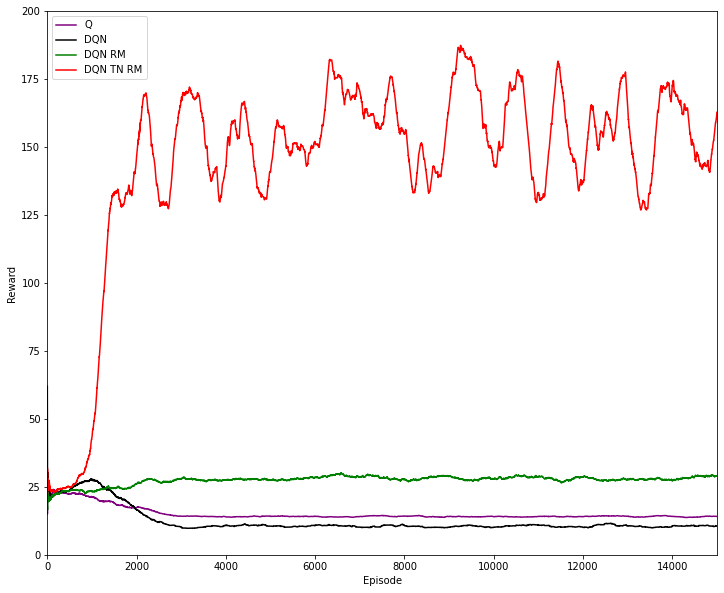

In [141]:
score_histories = [score_history_Q, score_history_DQN, score_history_DQN_RM, score_history_DQN_TN_RM]
labels = ["Q", "DQN", "DQN RM", "DQN TN RM"]
colors = ["purple", "black", "green", "red", "blue"]
plot_training("Episode", "Reward", score_histories, labels, colors, 500, NUM_ITERATIONS, 200, filename="Comparing Algorithms on CartPole.png")

# Conclusion

## Q
It was obvious that Q learning won't work because CartPole environment has 4 parameters in observation space and if we take 21 buckets, because space is continuous and we want to make it discrete, we will have too many non-explored states. Training for such model would take really long time. This method can work for environments with less parameters like MountainCar (2 parameters that are velocity and position), but it will still take around 30k episodes to train from my experience.

## DQN
It works, but it is highly unstable. We can see that because one episode it peaks and next episodes it drops down to random-action-like quality.

## DQN with Replay Memory
This method finally gives good results, but without the target network loss function is not performing properly. We can compare this to playing Hide and Seek in real life, but whenever we make a move to find a someone's location, person that is hiding also moves.

## DQN with Target Network and Replay Memory
This is by far the best and most stable method. Obvious improvement is to create Double DQN, Dueling DQN, Double Dueling DQN, etc. Using techniques such as prioritized replay memory could help aswell.